# mDPP

In [248]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('../../')

from omegaconf import DictConfig
import os

import torch
from torch.utils.data import DataLoader
import lightning as L

from rl4co.envs import DPPEnv, MDPPEnv
from rl4co.data.dataset import tensordict_collate_fn, TensorDictDataset
from rl4co.models import AttentionModel, AttentionModelPolicy
from rl4co.tasks.rl4co import RL4COLitModule
from rl4co.models.rl.reinforce.baselines import CriticBaseline, RolloutBaseline, WarmupBaseline, ExponentialBaseline
from rl4co.models.rl.reinforce.critic import CriticNetwork

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## mDPP Environment

We declare the environment here. This will automatically download the data 

In [249]:

data_dir = "../../data/"
data_file = "mdpp/mdpp10_test_seed1234.npz" # remember to generate data first


# In the mDPP problem we train directly on the test data as we want to search for best config
# of chip placement
env = MDPPEnv(reward_type="minmax", max_decaps=20, data_dir=data_dir,val_file=data_file, test_file=data_file)

In [250]:
dataset = env.dataset(phase="test")
batch = next(iter(DataLoader(dataset, batch_size=len(dataset), collate_fn=tensordict_collate_fn)))

init_td = env.reset(batch)
probes = init_td['probe'].clone().cpu()
keepouts = init_td['action_mask'].clone().cpu()


td = init_td.clone().cpu()

def heuristics_policy(td):
    # select the available location closest to the probe
    action_mask = td['action_mask']
    probes = td['probe']
    locs = td['locs']

    # Get distance matrix of all locations
    dist = torch.cdist(locs, locs, p=2)

    # Set distances between locations that are not probed to inf
    dist[~probes] = float("inf")

    # Get the shortest distance from probe to all locations
    min_dist, _ = torch.min(dist, dim=1)
    min_dist[~action_mask] = float("inf")

    # Get the location with the shortest distance
    action = torch.argmin(min_dist, dim=1)

    td.set("action", action)
    return td

actions = []

for i in range(20):
    # pick random action from action_mask
    td = heuristics_policy(td)
    actions.append(td['action'])
    td = env.step(td)['next']

actions = torch.stack(actions, dim=1)
rewards = env.get_reward(td, actions)
print(rewards.mean())

tensor(11.3039)


In [5]:
# rewards

# get topk indices of lowest reward
topk = torch.topk(rewards, k=10, largest=False)
print(topk.indices)

tensor([33, 50, 17, 86, 70, 51, 52, 63, 48,  7])


In [319]:
decaps = actions

# decaps to index
is_decap = torch.zeros_like(action_mask)
is_decap.scatter_(1, decaps, 1)

# x: locations tensor with shape (batch, n_loc, 2)
x = locs.clone()
# is_target: target mask tensor with shape (batch, n_loc)
is_target = is_decap.clone()
n_loc = x.shape[1] # number of locations



In [331]:
import torch


def calculate_density(x, is_target, radius=1.0):
    # compute pairwise distances
    # dists = pairwise_distance(x)
    dists = torch.cdist(x, x, p=2)

    # create an infinity tensor to mask the distances
    infinity = torch.full_like(dists, float('inf'))

    # use is_target tensor to mask dists
    # by setting distances to non-targets to infinity
    mask = ~is_target.unsqueeze(1).expand_as(dists)
    dists_masked = torch.where(mask, infinity, dists)

    # count the number of locations within a certain radius
    density = (dists_masked < radius).sum(dim=-1)

    return density


density = calculate_density(x, is_target, radius=.3)

density[0]

tensor([ 4,  7,  7,  7,  5,  3,  0,  0,  0,  0,  4,  7,  7,  8,  5,  3,  1,  0,
         0,  0,  5,  9, 10, 10,  8,  6,  2,  0,  0,  0,  5,  8, 10, 10,  8,  5,
         2,  0,  0,  0,  6,  8, 10, 11,  9,  5,  2,  0,  0,  0,  3,  6,  8,  7,
         7,  4,  2,  0,  0,  0,  3,  5,  8,  9, 11,  8,  6,  2,  1,  0,  2,  4,
         7,  9, 10,  8,  6,  3,  2,  0,  1,  3,  5,  7,  8,  7,  5,  3,  3,  1,
         0,  2,  3,  4,  6,  6,  5,  3,  2,  1])

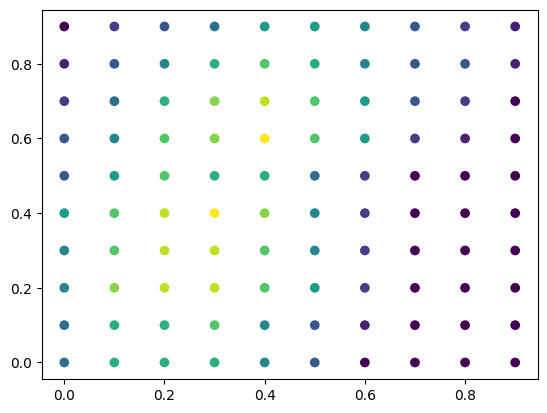

In [332]:
plt.scatter(x[0,:,0], x[0,:,1], c=density[0], cmap='viridis')

In [317]:
density

tensor([[ 9, 12, 15,  ..., 14, 15,  9],
        [15, 12, 12,  ..., 13, 14,  7],
        [ 0, 20, 14,  ..., 22, 10, 11],
        ...,
        [ 4, 15,  8,  ...,  8, 13,  1],
        [ 2, 18,  9,  ..., 12, 10, 16],
        [12,  7, 15,  ...,  2, 17, 18]])

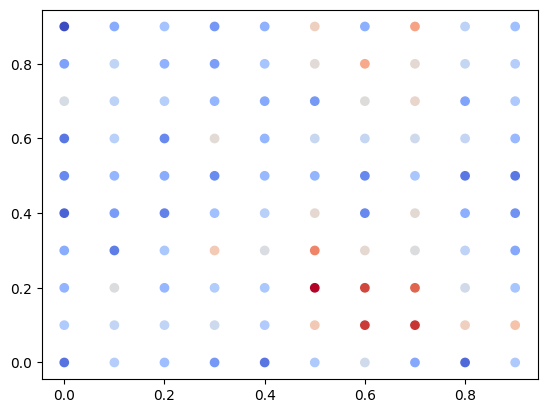

In [302]:
# decap_coefficient = sum(distances * is_decap) / sum(is_decap)

decaps = actions

# decaps to index
is_decap = torch.zeros_like(action_mask)
is_decap.scatter_(1, decaps, 1)

# Get distance matrix of all locations
dist = torch.cdist(locs, locs, p=2)

# feature to consider density of closeby decaps
# dist = torch.exp(-dist)

dist = dist * is_decap

dist = dist.sum(dim=1) / is_decap.sum(dim=1)

# set dist to 0 if not decap
# dist = dist * is_decap
# dist.scatter_(1, decaps, 0)



# plt.scatter(locs[0, :, 0], locs[0, :, 1], c=is_decap[0, :], cmap='coolwarm')

plt.scatter(locs[0, :, 0], locs[0, :, 1], c=dist[0, :], cmap='coolwarm')
# decaps = actions[0]

# locs_ = locs[0]
# probes_ = probes[0]


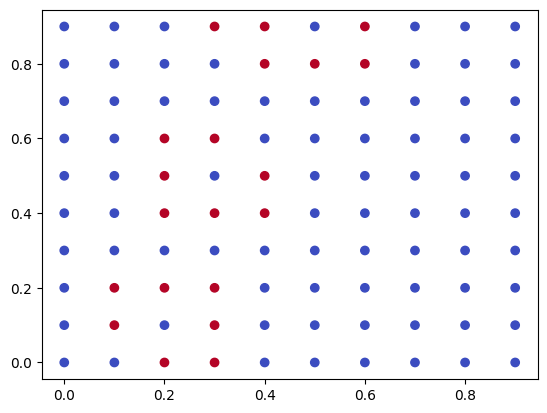

In [284]:
plt.scatter(locs[0, :, 0], locs[0, :, 1], c=is_decap[0, :], cmap='coolwarm')


In [262]:
dist.shape

torch.Size([100, 100, 100])

In [253]:
decaps

tensor([[96, 94, 43,  ..., 42, 44, 93],
        [85, 76, 82,  ..., 98, 62, 64],
        [73, 27, 75,  ..., 76, 26,  2],
        ...,
        [12,  3, 19,  ..., 33, 58, 57],
        [61, 72, 32,  ..., 23, 92, 83],
        [68, 86, 95,  ..., 31, 15, 33]])

In [92]:
# # Aggregate all actions with their relative distance to each location
# dist = torch.cdist(locs, locs, p=2)

# # action index to bool
# action_mask = torch.zeros_like(action_mask).scatter_(1, actions, 1)
# dist_masked = dist * action_mask #action_mask[..., None].repeat(1, 1, dist.shape[2])

# # Get sum of distances for each action
# dist_sum = dist_masked.sum(dim=2) / action_mask.sum(dim=1)

In [105]:
dist.shape

torch.Size([100, 100, 100])

In [106]:
# get number of actions closer to a port

# assign index of port to each action depending on the closest port
dist = torch.cdist(locs, locs, p=2)
dist[~probes] = float("inf")
min_dist, min_dist_idx = torch.min(dist, dim=1)

dist = torch.cdist(locs, locs, p=2)
# get index of port for each action



In [247]:
probe_locs.shape

torch.Size([328, 2])

In [244]:
probes = td['probe']

probe_locs = locs[probes]

locs = td['locs']

# mark each loc with closest probe
dist = torch.cdist(locs, probe_locs, p=2)
min_dist, min_dist_idx = torch.min(dist, dim=1)


print(min_dist_idx.shape)

torch.Size([100, 328])


In [240]:
# for each location, make sum(probe_loc / distance from probe) 
probes = td['probe']
locs = td['locs']


# for loc in locs:
    # sum(probe_loc / distance from probe)
    # sum(distances from probe)
    # take dist from probe to each location
dist = torch.cdist(locs, locs, p=2)
# make inf to 0
# dist[~probes] = 0
# where inf, set to 0
# dist = torch.where(dist == float("nan"), torch.zeros_like(dist), dist)
# set all nan to 0
# dist[torch.isnan(dist)] = 0

# sum all distances
# make dist 0 if probe is not there
dist[~probes] = 0

num_probes = probes.sum(dim=1)

dist_sum = dist.sum(dim=1)
    


In [241]:
print(num_probes)

tensor([3, 2, 3, 4, 3, 3, 4, 5, 4, 2, 3, 3, 3, 5, 4, 2, 2, 5, 2, 2, 4, 2, 2, 2,
        2, 3, 2, 4, 3, 5, 2, 4, 2, 5, 4, 4, 5, 5, 4, 4, 3, 5, 2, 2, 3, 3, 4, 4,
        5, 3, 2, 5, 4, 2, 3, 3, 3, 2, 2, 3, 5, 5, 2, 2, 2, 3, 3, 2, 4, 5, 3, 3,
        4, 3, 5, 5, 5, 3, 5, 2, 2, 3, 2, 3, 5, 4, 3, 3, 4, 4, 4, 3, 2, 5, 2, 2,
        2, 2, 2, 5])


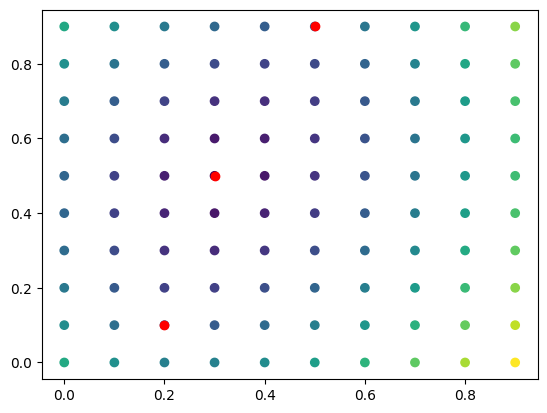

In [228]:
# scatter dist_sum to actions
plt.scatter(locs[0,:,0], locs[0,:,1], c=dist_sum[0])


# probe_locations = locs[probes]
probe_locations = torch.where(probes[...,None].expand(-1,-1,2), locs, float("inf"))
plt.scatter(probe_locations[0,:,0], probe_locations[0,:,1], c="r")

In [201]:
locs.shape

torch.Size([100, 100, 2])

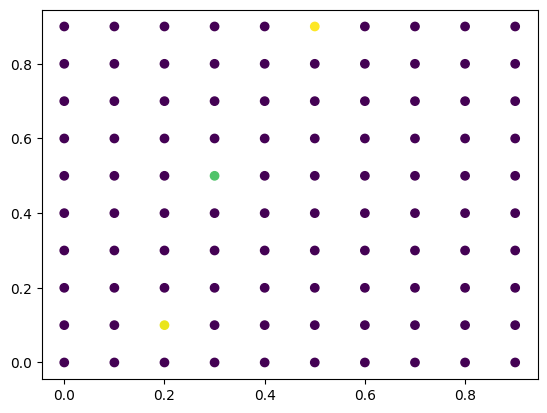

In [203]:
# scatter dist_sum to actions
plt.scatter(locs[0,:,0], locs[0,:,1], c=dist_sum[0])

In [197]:
# dist_sum.max()

tensor(70.0305)

In [186]:
dist_sum

tensor([[    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        ...,
        [    nan,     nan, 60.0098,  ...,     nan,     nan,     nan],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan]])

In [239]:
unavailable, keepouts, probes = (
    ~td["action_mask"].clone(),
    td["keepout"].clone(),
    td["probe"].clone(),
)

# Absolute encoding?
placed_decaps = unavailable & ~(keepouts | probes)

In [236]:
placed_decaps[0].float()

tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 1., 0., 0., 0.])

In [235]:
# sorted(actions[0])
a = torch.zeros(100)
a.scatter_(0, actions[0], 1)
a

tensor([0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 1., 1., 0., 1., 0., 0., 0.])

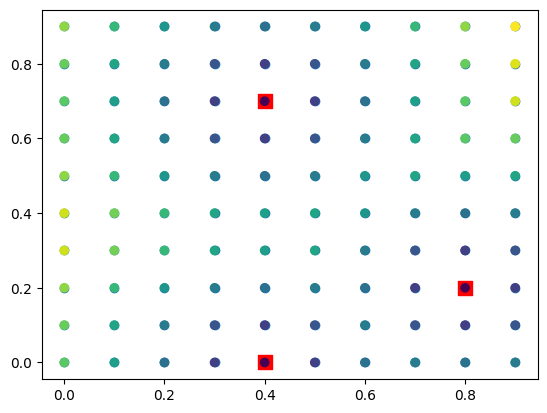

In [16]:
# Plot scatter plot of locations as meshgrid

import matplotlib.pyplot as plt


probes = td['probe']
locs = td['locs']

# Get distance matrix of all locations
dist = torch.cdist(locs, locs, p=2)

# Set distances between locations that are not probed to inf
dist[~probes] = float("inf")

# Get the shortest distance from probe to all locations
min_dist, _ = torch.min(dist, dim=1)



idx = 2

# plt.scatter(locs[0, :, 0], locs[0, :, 1])
plt.scatter(locs[idx, :, 0], locs[idx, :, 1])

# Plot probe locations as rectangle
plt.scatter(locs[idx, probes[idx], 0], locs[idx, probes[idx], 1], c="r", marker="s", s=100)

# Plot gradient of min distance
plt.scatter(locs[idx, :, 0], locs[idx, :, 1], c=min_dist[idx], cmap="viridis")

Reward: tensor(5.5353)


/mnt/HDD/botu/botu/Dev/rl4co/notebooks/dpp/../../rl4co/envs/mdpp.py:324: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.Rectangle(


Reward: tensor(7.4886)
Reward: tensor(7.5405)


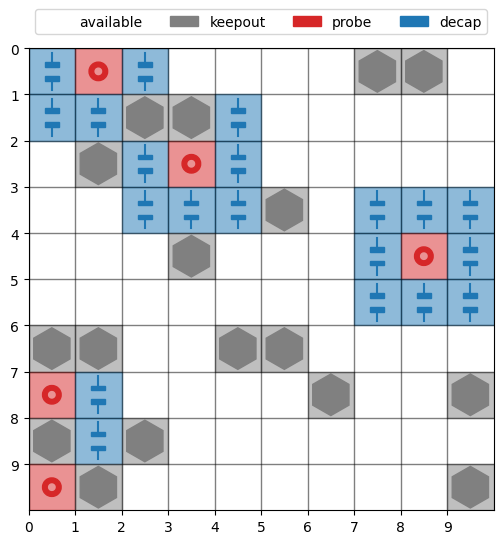

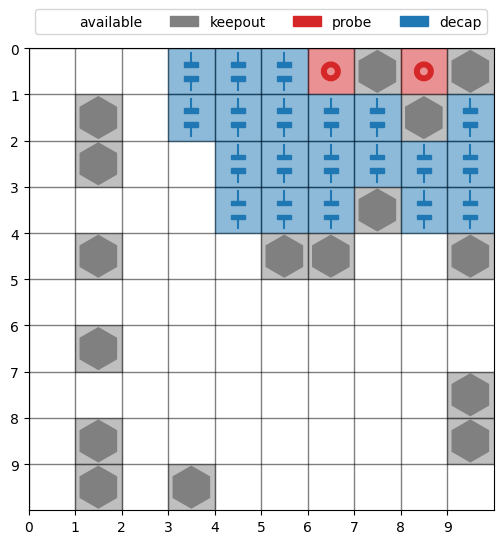

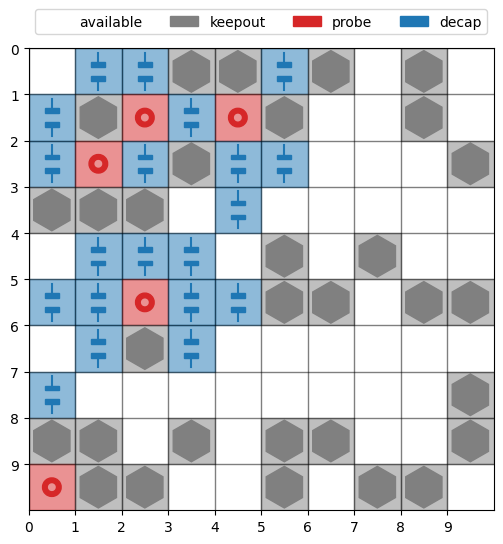

In [6]:

probes = td['probe'].clone().cpu()
keepouts = td['action_mask'].clone().cpu()


for i in [33, 50, 17]:
    print("Reward:", rewards[i])
    env.render(init_td[i], actions[i])


## Context

In [10]:
min_dist.shape

torch.Size([100, 100])

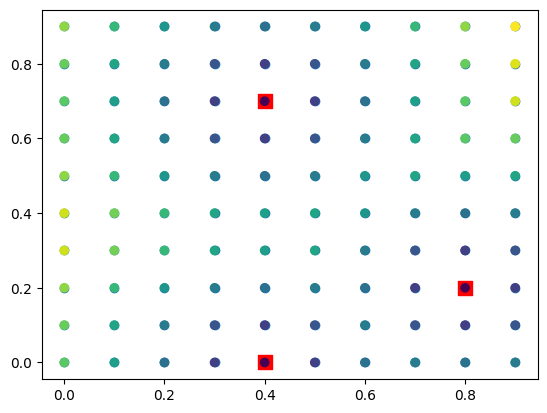

In [6]:
# Plot scatter plot of locations as meshgrid

import matplotlib.pyplot as plt


probes = td['probe']
locs = td['locs']

# Get distance matrix of all locations
dist = torch.cdist(locs, locs, p=2)

# Set distances between locations that are not probed to inf
dist[~probes] = float("inf")

# Get the shortest distance from probe to all locations
min_dist, _ = torch.min(dist, dim=1)



idx = 2

# plt.scatter(locs[0, :, 0], locs[0, :, 1])
plt.scatter(locs[idx, :, 0], locs[idx, :, 1])

# Plot probe locations as rectangle
plt.scatter(locs[idx, probes[idx], 0], locs[idx, probes[idx], 1], c="r", marker="s", s=100)

# Plot gradient of min distance
plt.scatter(locs[idx, :, 0], locs[idx, :, 1], c=min_dist[idx], cmap="viridis")